In [25]:
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.lines as mlines

import pymc as mc

import pandas as pd
import numpy as np

import datetime

In [2]:
import vpfits

# VPfits

The VPfits module contains a class, `VPfit`, that carries out most of the heavy lifting. First we create an instance of this class.

In [3]:
vpfit = vpfits.VPfit()

## Mock Spectra

`VPfit` contains a function for creating mock absoprtion profiles, `mock_absorption`. Just tell it how many features you wish to include. It returns a dataframe, `clouds`, containing each feature, and an array of wavelength values. It can also plot the profile.

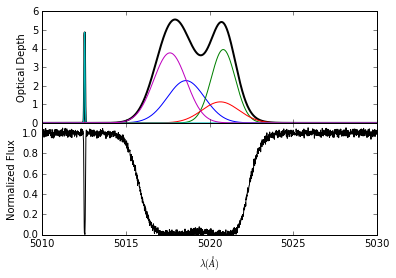

In [4]:
n = 5

clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True)

The plot shows the profile with added noise, but right now doesn't return this noisy profile, so we recreate it here.

In [5]:
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))
flux_array = vpfit.Absorption(sum(clouds['tau'])) + noise

To fit, initialise the model with `n` profiles, calculate the MAP estimate, then run the MCMC.

In [6]:
vpfit.initialise_model(wavelength_array, flux_array, n)

In [7]:
vpfit.map_estimate()

In [8]:
vpfit.mcmc_fit()

Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 25.0 sec
Took: 0:00:24.989520  to finish.


Our `VPfit` instance, `vpfit`, now contains the fitted profile components.

We can query some features of the fit useful for model selection, such as the Maximum A Posteriori (MAP) Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC).

In [9]:
print vpfit.MAP.BIC
print vpfit.MAP.AIC

-9304.55681409
-9394.17125344


We also have model selection metrics from the MCMC

In [10]:
print vpfit.mcmc.BPIC
print vpfit.mcmc.DIC

-9805.37451032
-9793.33894437


In [11]:
vpfits.VPfit.Chisquared(vpfit.total.value, flux_array)

5.0779613154870722

In [12]:
vpfits.VPfit.ReducedChisquared(vpfit.total.value, flux_array, len(vpfit.estimated_variables))

0.002545344017788006

Finally, we can also plot the fit, with residuals. The fitted components and actual components can be directly compared.

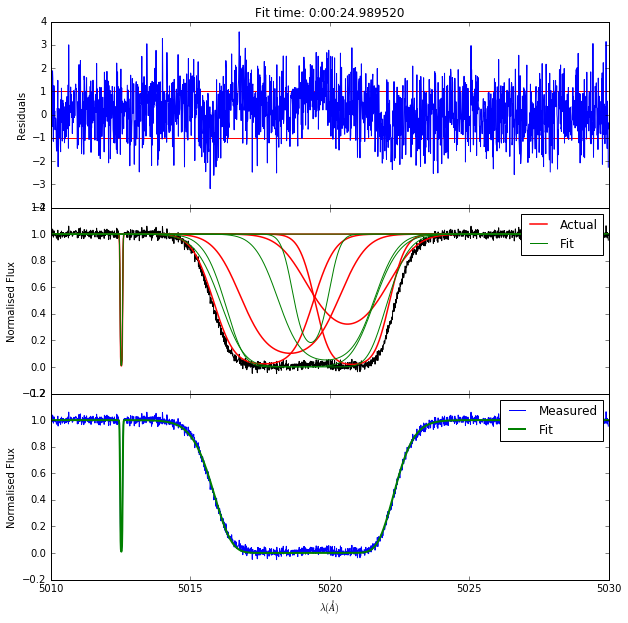

In [13]:
vpfit.plot(wavelength_array, flux_array, clouds, n=n)

# Region Detection

Regions are detected based on a detection threshold of 4 sigma. The number of pixels needed below the threshold to divide regions is set with `buffer`, and the minimum width of a region is set with `min_region_width` in pixels.

The `compute_detection_regions` function outputs a numpy array of the start and end wavelengths of each region.

In [14]:
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))
noise_vector = [onesigmaerror]*len(noise)
flux_array = vpfit.Absorption(sum(clouds['tau'])) + noise

In [15]:
min_region_width = 3
regions = vpfits.compute_detection_regions(wavelength_array, flux_array, noise_vector, 
                                          min_region_width=min_region_width)
print(regions)

Computing detection regions...
Found 2 detection regions.
[[ 5012.45  5012.63]
 [ 5014.53  5023.48]]


In [16]:
region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(wavelength_array==region[0])[0][0]
    end = np.where(wavelength_array==region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([wavelength_array[start:end], flux_array[start:end]])

In [17]:
def plot_bracket(x, dir):
    height = .2
    arm_length = 0.2
    pylab.plot((x, x), (1-height/2, 1+height/2), color='magenta')
    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length
    pylab.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    pylab.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

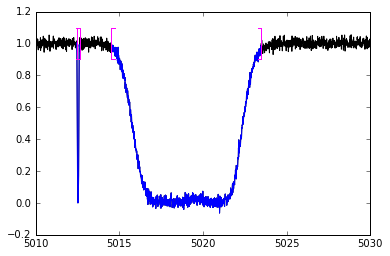

In [18]:
pylab.plot(wavelength_array, flux_array, c='black')

for arr in region_arrays:
    pylab.plot(arr[0], arr[1], color='blue')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')
    
pylab.show()

## Finding the right number of profiles

In a complicated spectrum, knowing how many components there are can be difficult. `VPfits` can perform model selection on two fits with different numbers of profiles to determine which is the best.

Below is an early implementation using the Bayesian Information Criterion (BPIC) as a threshold.

 n:  2
Fit 1 BIC:  -87.636702613 , Fit 2 BIC:  -78.9793175764
Fit 1 CSL 1.35043989566 | Fit 2 CS: 1.33051289756
BIC Ratio:  1.1096158501
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 2.1 sec
Took: 0:00:02.070806  to finish.
245 263


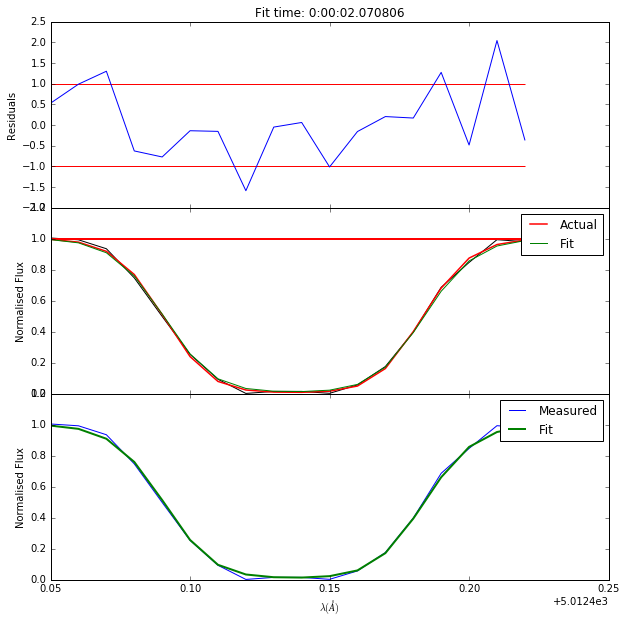

n:  2
Fit 1 BIC:  -4117.03726141 , Fit 2 BIC:  -4196.30758963
Fit 1 CSL 5.52363093382 | Fit 2 CS: 4.62809166096
BIC Ratio:  0.981109504838
n:  3
Fit 1 BIC:  -4196.30758963 , Fit 2 BIC:  -4180.89166641
Fit 1 CSL 4.62809166096 | Fit 2 CS: 4.82717407331
BIC Ratio:  1.00368723336
n (final):  2
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 8.9 sec
Took: 0:00:08.920120  to finish.
453 1348


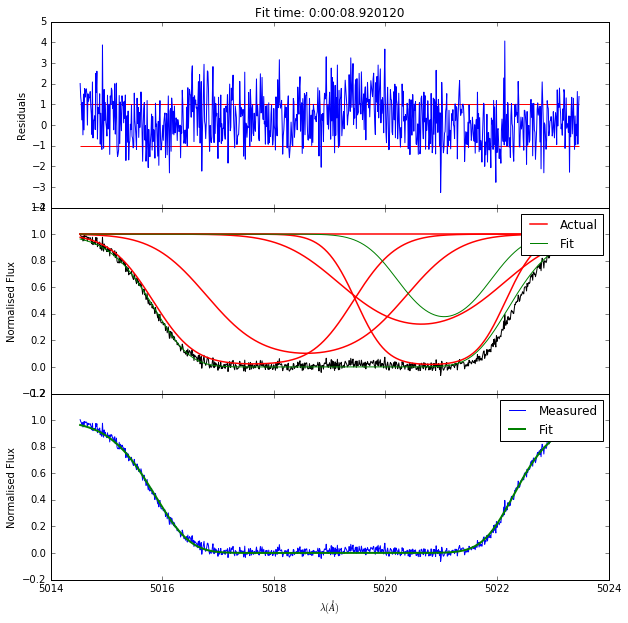

In [20]:
fits = []

for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelengths, fluxes, n)
    vpfit_2.map_estimate()

    while r < 1:

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n)
        vpfit_2.map_estimate()

        print "Fit 1 BIC: ", vpfit_1.MAP.BIC, ", Fit 2 BIC: ", vpfit_2.MAP.BIC
        
        print "Fit 1 CSL", vpfits.VPfit.Chisquared(vpfit_1.total.value, fluxes), "| Fit 2 CS:", \
            vpfits.VPfit.Chisquared(vpfit_2.total.value, fluxes)
            
        print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC

        r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    n -= 1
    print "n (final): ", n
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    print start, end
    
    vpfit_1.plot(wavelengths, fluxes, clouds, n, start_pix=start, end_pix=end)

Finally, we can plot the detection regions and the fitted profiles over the entire spectrum.

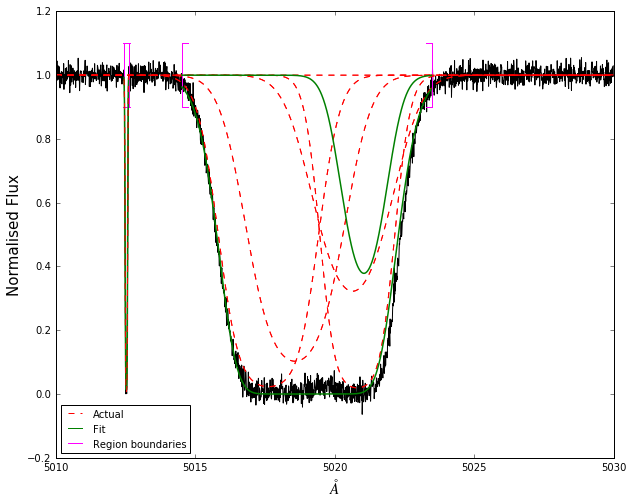

In [35]:
fig, ax = pylab.subplots(figsize=(10,8))

ax.plot(wavelength_array, flux_array, c='black')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')

for i in range(len(fits)):
    fit = fits[i]
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    for c in range(len(clouds)):
        ax.plot(wavelength_array, fit.Absorption(clouds.ix[c]['tau']), color="red", ls='--')
        
    for prof in fit.estimated_profiles:
        ax.plot(wavelengths, fit.Absorption(prof.value), color='green', lw=1.5)
        

handles = [mlines.Line2D([], [], color='red', label='Actual', ls='--'), mlines.Line2D([], [], color='green', label='Fit'),
          mlines.Line2D([], [], color='magenta', label='Region boundaries')]

ax.legend(handles=handles, prop={'size':10}, loc='best')

ax.set_xlabel('$\AA$', size=15)
ax.set_ylabel('Normalised Flux', size=15)